In [1]:
import os
import warnings
import time

import numpy as np 

from scipy.stats import chisquare

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std, gaussian_sigma_to_fwhm
from astropy.table import Table
from astropy.modeling import models, fitting, functional_models, Parameter, custom_model
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.utils.exceptions import AstropyWarning
from astropy import units as u
from astropy.convolution import convolve

from astropy.stats import gaussian_fwhm_to_sigma

from photutils import detect_threshold
from photutils import deblend_sources
from photutils import source_properties
from photutils import detect_sources
from photutils import source_properties, EllipticalAperture

from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.stats import SigmaClip

from photutils import Background2D, MedianBackground
from photutils import DAOStarFinder
from photutils import aperture_photometry, CircularAperture, CircularAnnulus, EllipticalAnnulus

In [2]:
from lcbg.utils import cutout, measure_fwhm, plot_apertures
from lcbg.fitting import plot_fit, fit_model, model_subtract, Moffat2D, Nuker2D
from lcbg.segmentation import plot_segment_residual, plot_segments, make_segments, deblend_segments
from lcbg.photometry import flux_to_abmag

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

In [4]:
import ipywidgets as widgets
from IPython.display import display

# Define Paths

In [5]:
filter_list = ['f105w', 'f125w', 'f140w', 'f160w']
ad_filter_list = ['MAG_Y105', 'MAG_J125', 'MAG_JH140', 'MAG_H160'] # Astrodeep version of filters

In [6]:
input_data_formatter = "https://archive.stsci.edu/pub/hlsp/frontier/abell2744/images/hst/v1.0-epoch1/hlsp_frontier_hst_wfc3-60mas_abell2744_{}_v1.0_drz.fits"

# Determine a Good Cutout Coord for Noise Estimate

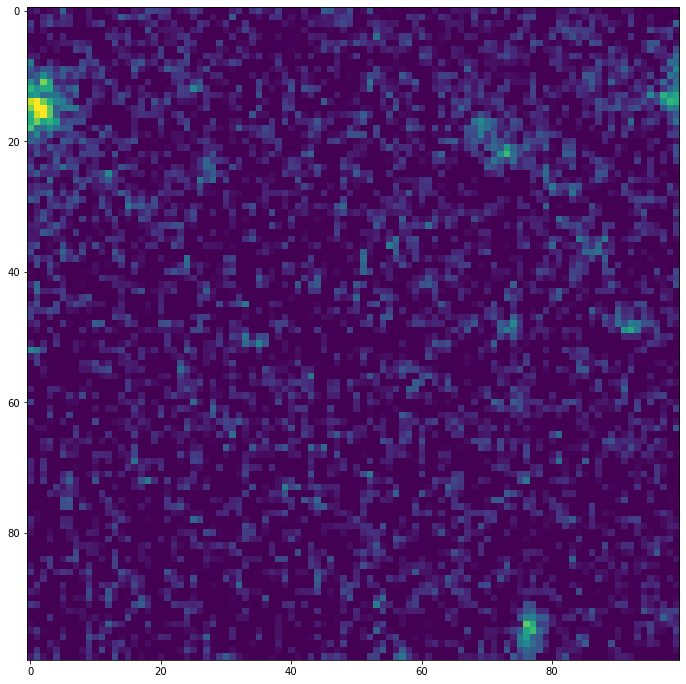

In [7]:
input_data_path = input_data_formatter.format('f105w')

hdul = fits.open(input_data_path)
hdu = hdul[0]

data = hdu.data
header = hdu.header
wcs = WCS(header)

subsection = cutout(data, 2779, 3390,  100)
plt.imshow(subsection, vmin=0, vmax=2.9534784e-05*350)


# Do Aperture Photomerty

In [38]:

cat = None
cat_smoothed = None 
single_aperture_photometry_table = None

for current_filter in filter_list:
    print(current_filter)
    
    # Load data and vitals
    # ---------------------
    
    input_data_path = input_data_formatter.format(current_filter)
    output_path = "{}_catalog.csv".format(os.path.splitext(os.path.basename(input_data_path))[0])

    hdul = fits.open(input_data_path)
    hdu = hdul[0]

    data = hdu.data
    header = hdu.header
    wcs = WCS(header)

    
    # Cutout Image
    # ------------
    
    # Estimate data noise
    subsection = cutout(data, 2779, 3390,  150)
    mean_noise = subsection.mean()
    
    # Select and crop image:
    cx, cy = [int(np.round(i)) for i in wcs.world_to_pixel_values(header["RA_TARG"], header["DEC_TARG"])]
    image = cutout(data, cx, cy, 2000)
    
    image_wcs = wcs.copy()
    delta_pix = np.array([cx, cy]) - np.array(image.shape)//2
    image_wcs.wcs.crpix = np.array(image_wcs.wcs.crpix) - delta_pix
    
    image -= mean_noise
    image = np.clip(image, 0, image.max())
    

    # Catalog
    # -------
    
    nsigma = np.zeros_like(image) + image.mean() / 3
    #nsigma = np.unique(detect_threshold(image, nsigma=3.))[0]
    segm = make_segments(image, nsigma=nsigma, kernel_size=None)
    
    segm_deblend = deblend_segments(image, segm)
    
    cat = source_properties(image, segm_deblend, wcs=image_wcs)
        
    # Photomerty
    # ----------
    
    r = 4  # approximate isophotal extent
    
    aperture_photometry_results = []
    for obj in cat:
        position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
        
        a = obj.semimajor_axis_sigma.value * r
        b = obj.semiminor_axis_sigma.value * r
        theta = obj.orientation.to(u.rad).value
        
        aperture = EllipticalAperture(position, a, b, theta=theta)
        annulus = EllipticalAnnulus(position, a, a*2, b*2)
        
        photometric_sum = aperture.do_photometry(image)[0][0] 
        photometric_bkg = aperture.area * (annulus.do_photometry(image)[0][0] / annulus.area)
        
        photometric_value = photometric_sum - photometric_bkg
        
        aperture_photometry_results.append(photometric_value)
    aperture_photometry_results = np.array(aperture_photometry_results)
        
    
    # Make and save final catalog
    # ---------------------------
    single_aperture_photometry_table = cat.to_table()
    single_aperture_photometry_table['aperture_sum'.format(current_filter)] =  aperture_photometry_results
    single_aperture_photometry_table['ab_mag'.format(current_filter)] = flux_to_abmag(np.array(aperture_photometry_results), header)
    single_aperture_photometry_table.write(output_path, format="ascii.csv", overwrite=True)
    
    plt.show()


    #print("\n"*6)
  



f105w
f125w
f140w
f160w


# Compare Catalogs

In [39]:
astro_deep_cat = Table.read("https://stsci.box.com/shared/static/2dsckrbt7b4eocl2v2mot9ssso0stc11.cat", format="ascii")

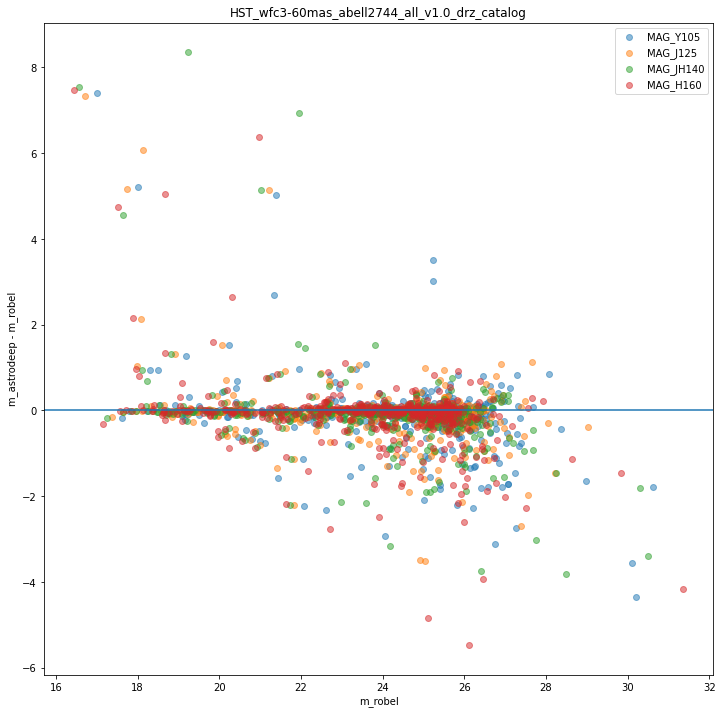

In [40]:

for filt, ad_filt in zip(filter_list, ad_filter_list):
    cat = Table.read("hlsp_frontier_hst_wfc3-60mas_abell2744_{}_v1.0_drz_catalog.csv".format(filt), format='ascii.csv')
    
    ad_values = []
    cat_values = []
    for row in cat:
        ra, dec = [float(i) for i in row['sky_centroid'].split(',')]
        mag = row['ab_mag']

        idx = ((astro_deep_cat['RA'] - ra)**2 + (astro_deep_cat['DEC'] - dec)**2).argmin()
        ad_mag = astro_deep_cat[idx][ad_filt]

        if ad_mag < 99 and  -10 < (ad_mag - mag) < 10:
            ad_values.append(ad_mag - mag)
            cat_values.append(mag)
            
    plt.scatter(cat_values, ad_values, alpha=0.5, label=ad_filt)
            
plt.axhline(0)
plt.legend()
plt.title("HST_wfc3-60mas_abell2744_all_v1.0_drz_catalog")
plt.xlabel("m_robel")
plt.ylabel("m_astrodeep - m_robel");